In [21]:
import numpy as np
import matplotlib.pyplot as plt
from models_vector import leapfrog_sampler
import jax
from jax.random import normal,PRNGKey
import jax.numpy as jnp
import jax.scipy.stats as jst
import seaborn as sns

root_seed=123875938745
key = PRNGKey(root_seed)

In [22]:
# mu = np.array([1,.8])
# cov = np.array([[.6, 0.3],[0.3, .5]]) # std is the square root of the eigenvalues of cov
mu = np.zeros(2)
cov = np.diag([.25,1])
# mu = np.zeros(2)
# cov = np.eye(2)
gaussian = lambda x: jst.multivariate_normal.pdf(x, mu, cov)
U = lambda x: -jst.multivariate_normal.logpdf(x, mu, cov)
num_walkers = 3
q_init, p_init = normal(key, (2, num_walkers, 2))

trajectories = leapfrog_sampler(U, q_init, p_init, num_steps=6, step_size=.5)

 iter: 4

(-3.0, 3.0)

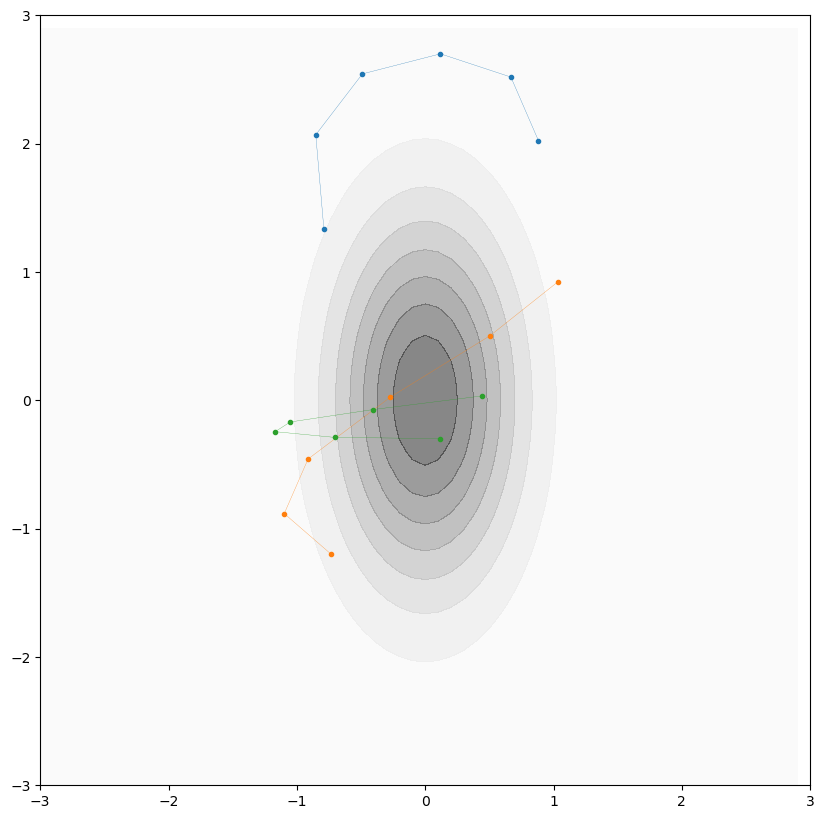

In [23]:
x_lim = [-3, 3]
y_lim = [-3, 3]
x, y = np.meshgrid(np.arange(*x_lim, .1), np.arange(*y_lim, .1))
pos = np.dstack((x, y))

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
# contours = ax.contourf(x, y, U(pos), linewidths=2, alpha=0.5, cmap="Greys")
contours = ax.contourf(x, y, np.exp(-U(pos)), alpha=0.5, cmap="Greys")

for i in range(len(trajectories)):
    ax.plot(*trajectories[i], '.-', linewidth=.2)
# ax[0][2].clabel(contours, inline=1, fontsize=10)
ax.set_ylim(*x_lim)
ax.set_xlim(*y_lim)

### Trajectory tempering multivariate gaussian

In [24]:
from test_functions import neg_log_mix, neg_log_mvnormal

mu1 = np.ones(2)
cov1 = 0.5 * jnp.array([[1., 0.7], [0.7, 1.]])
mu2 = -mu1
cov2 = 0.2 * jnp.array([[1., -0.6], [-0.6, 1.]])
mu3 = jnp.array([-1., 2.])
cov3 = 0.3 * jnp.eye(2)
params = [(mu1, cov1),( mu2, cov2),(mu3, cov3)]

g1 = lambda x: jst.multivariate_normal.pdf(x, mu1, cov1)
g2 = lambda x: jst.multivariate_normal.pdf(x, mu2, cov2)
g3 = lambda x: jst.multivariate_normal.pdf(x, mu3, cov3)
g_mix = lambda x: g1(x) + g2(x) + g3(x)

neg_log_probs = [neg_log_mvnormal(mu, sigma) for mu,sigma in params]
U = neg_log_mix(neg_log_probs, jnp.array([0.3, 0.3, 0.4]))

num_walkers = 3
M = .1
q_init, p_init = normal(key, (2, num_walkers, 2))*jnp.sqrt(10)
# q_init = np.array([[-1.5,2]])
# p_init = normal(key, (1,2))

trajectories = leapfrog_sampler(U, q_init, p_init, num_steps=300, step_size=.03, M=M, temper=1.0)

 iter: 298

(-3.0, 3.0)

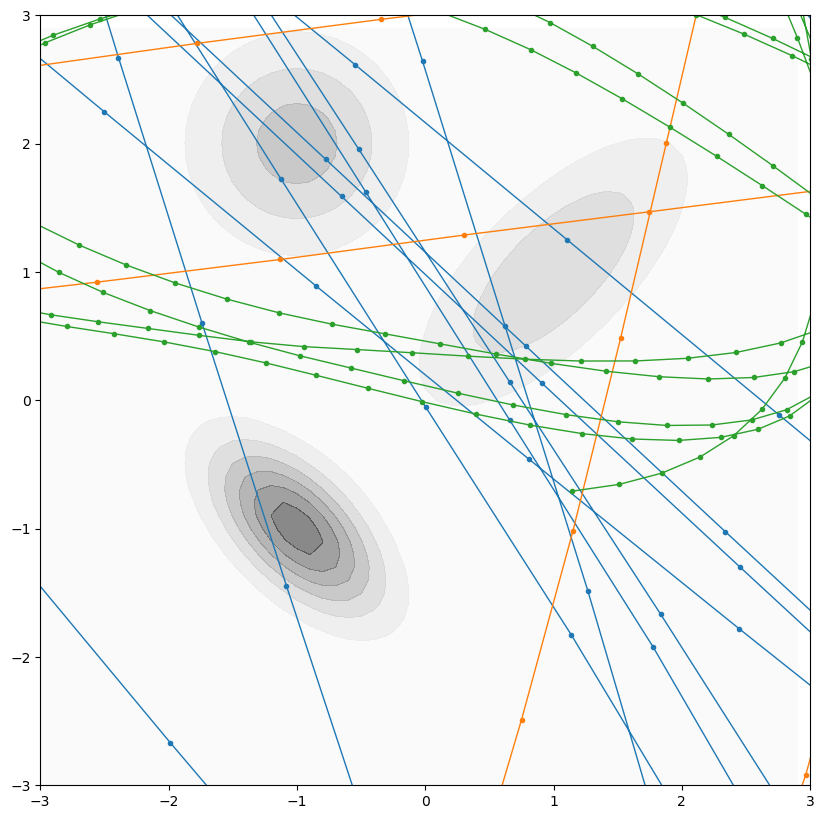

In [25]:
x_lim = [-3, 3]
y_lim = [-3, 3]
x, y = np.meshgrid(np.arange(*x_lim, .1), np.arange(*y_lim, .1))
pos = np.dstack((x, y))
# pos = np.stack((x.ravel(),y.ravel())).T

fig, ax = plt.subplots(figsize=(10,10))
ax.set_aspect('equal')
# contours = ax.contourf(x, y, U(pos).reshape(x.shape), linewidths=2, alpha=0.5, cmap="Greys")
contours = ax.contourf(x, y, g_mix(pos), alpha=0.5, cmap="Greys")

for i in range(len(trajectories)):
    ax.plot(*trajectories[i], '.-', linewidth=1)
    
ax.set_ylim(*x_lim)
ax.set_xlim(*y_lim)

### Divergence in a funnel

In [20]:
from test_functions import neg_log_funnel
from scipy.stats import norm

U = neg_log_funnel()

num_walkers = 1
step_sizes = [0.02, .05, .1, .25]
q_init, p_init = .5*normal(key, (2, num_walkers, 2))
trajectories = []

for step_size in step_sizes:
    trajectories.append(leapfrog_sampler(U, q_init, p_init, num_steps=300, M=.1, step_size=step_size))

 iter: 172

KeyboardInterrupt: 

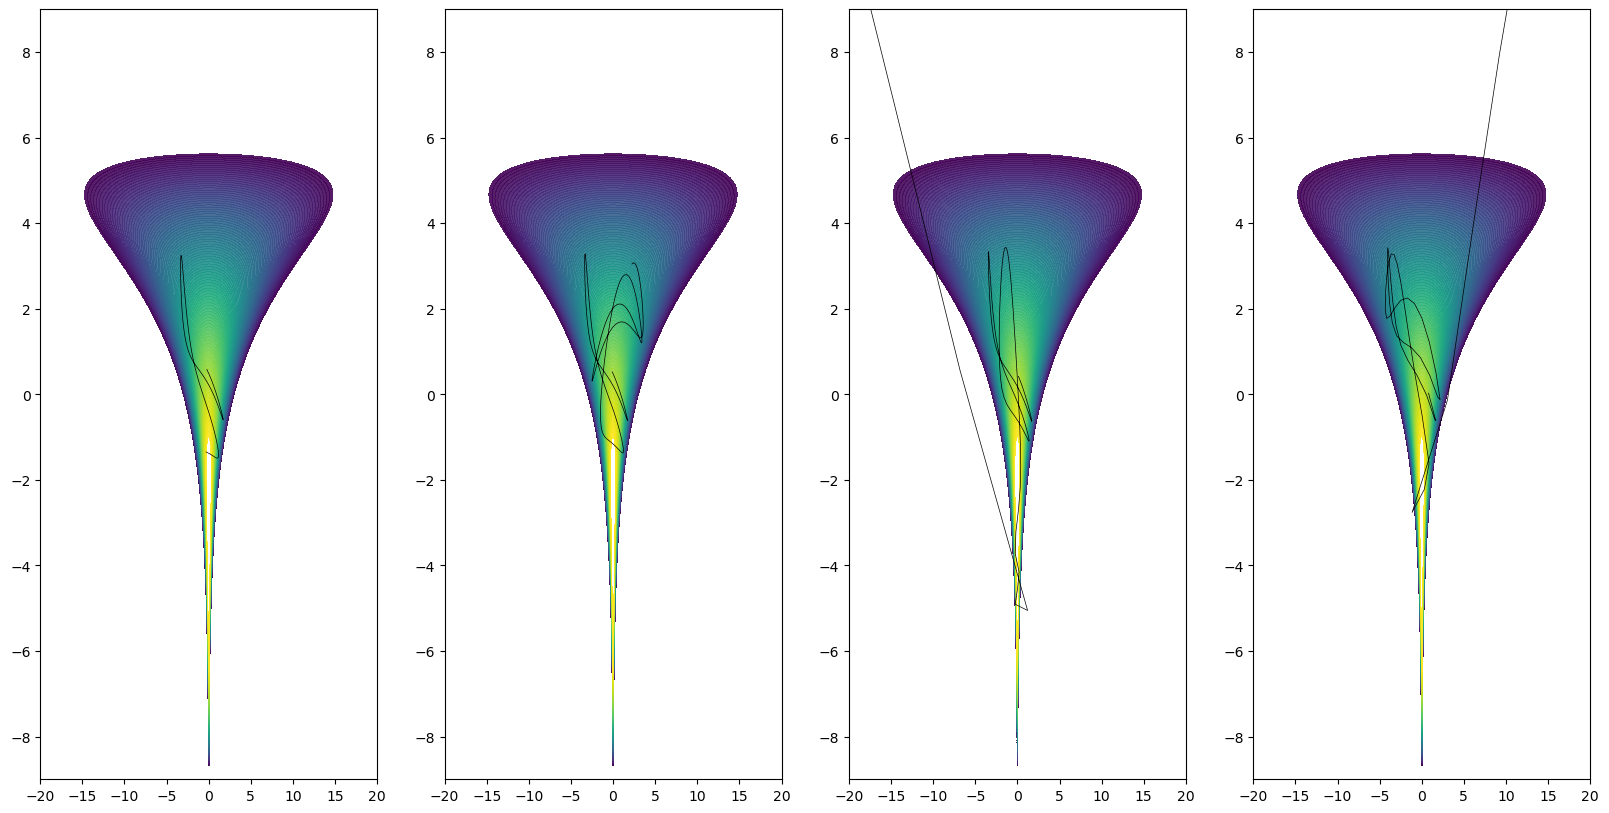

In [ ]:
x_lim = [-20, 20]
y_lim = [-9, 9]
x, y = np.meshgrid(np.linspace(*x_lim, 500), np.linspace(*y_lim, 500))
pos = np.dstack((x, y))
# logp = norm.logpdf(y, 0, 3) + norm.logpdf(x, 0, np.exp(y/2))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(1,len(step_sizes),figsize=(20,10))
# ax[0].contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
# ax[0].imshow(logp, vmin=-7.5, vmax=-2.5, cmap="Greys", origin="lower")

for i, traj in enumerate(trajectories):
    ax[i].contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,100), alpha=0.9)
    for j in range(len(traj)):
        ax[i].plot(*traj[j], '-', c='k', linewidth=.5)

    ax[i].set_xlim(*x_lim)
    ax[i].set_ylim(*y_lim)